<img src="./images/coronavirus_icon-1.jpg" style="float: left; margin: 20px; height: 75px">

# **Capstone: Covid-19 Study**

# 3.  Modeling

In [111]:
# Import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, StackingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.utils.plotting import plot_series
import sktime
import statsmodels
import pmdarima as pmd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# Read in Datasets

merged_1_corr = pd.read_csv('../us_datasets/merged_1_corr.csv')
merged_2_corr = pd.read_csv('../us_datasets/merged_2_corr.csv')
merged_3_corr = pd.read_csv('../us_datasets/merged_3_corr.csv')
merged_1_corr_ratio = pd.read_csv('../us_datasets/merged_1_corr_ratio.csv')
time_series_df = pd.read_csv('../us_datasets/time_series_df.csv')

In [3]:
us_epidemiology = pd.read_csv('../us_datasets/us_epidemiology.csv', index_col = 'location_key')
us_index_merge_on = pd.read_csv('../us_datasets/us_index_merge_on.csv', index_col = 'location_key')

## Create Linear Regression Models for Inferential Analysis

### Iteration 1: Fit LR models to three datasets: 01-01-2021, 09-01-2021, 05-13-2022

In [63]:
# Create X and y variables for three lr models

x1 = merged_1_corr.drop(columns = ['cumulative_confirmed', 'new_confirmed', 'Unnamed: 0'])
x1r = merged_1_corr_ratio.drop(columns = ['cumulative_confirmed', 'cov_confirmed_pop_ratio', 'Unnamed: 0'])
x2 = merged_2_corr.drop(columns = ['cumulative_confirmed', 'new_confirmed', 'Unnamed: 0'])
x3 = merged_3_corr.drop(columns = ['cumulative_confirmed', 'new_confirmed', 'Unnamed: 0'])

y1 = merged_1_corr['cumulative_confirmed']
y1r = merged_1_corr_ratio['cov_confirmed_pop_ratio']
y2 = merged_2_corr['cumulative_confirmed']
y3 = merged_3_corr['cumulative_confirmed']

In [64]:
# Train test split each dataset

x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, random_state = 42)
x1r_train, x1r_test, y1r_train, y1r_test = train_test_split(x1r, y1r, random_state = 42)
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, random_state = 42)
x3_train, x3_test, y3_train, y3_test = train_test_split(x3, y3, random_state = 42)

In [65]:
# Scale, fit each model

sc1 = StandardScaler()
x1_train_sc = sc1.fit_transform(x1_train)
x1_test_sc = sc1.transform(x1_test)

sc1r = StandardScaler()
x1r_train_sc = sc1r.fit_transform(x1r_train)
x1r_test_sc = sc1r.transform(x1r_test)

sc2 = StandardScaler()
x2_train_sc = sc2.fit_transform(x2_train)
x2_test_sc = sc2.transform(x2_test)

sc3 = StandardScaler()
x3_train_sc = sc3.fit_transform(x3_train)
x3_test_sc = sc3.transform(x3_test)

lr1 = LinearRegression()
lr1.fit(x1_train_sc, y1_train)

lr1r = LinearRegression()
lr1r.fit(x1r_train_sc, y1r_train)

lr2 = LinearRegression()
lr2.fit(x2_train_sc, y2_train)

lr3 = LinearRegression()
lr3.fit(x3_train_sc, y3_train)

LinearRegression()

In [66]:
# Calculate train/test R2 scores for each model

print("01-01-2021 Dataset")
print(f'Training R2: {round(lr1.score(x1_train_sc, y1_train),3)}')
print(f'Testing R2: {round(lr1.score(x1_test_sc, y1_test),3)}')
print('='*26)
print("01-01-2021 Ratio Dataset")
print(f'Training R2: {round(lr1r.score(x1r_train_sc, y1r_train),3)}')
print(f'Testing R2: {round(lr1r.score(x1r_test_sc, y1r_test),3)}')
print('='*26)
print("09-01-2021 Dataset")
print(f'Training R2: {round(lr2.score(x2_train_sc, y2_train),3)}')
print(f'Testing R2: {round(lr2.score(x2_test_sc, y2_test),3)}')
print('='*26)
print("05-13-2022 Dataset")
print(f'Training R2: {round(lr3.score(x3_train_sc, y3_train),3)}')
print(f'Testing R2: {round(lr3.score(x3_test_sc, y3_test),3)}')

01-01-2021 Dataset
Training R2: 0.952
Testing R2: 0.86
01-01-2021 Ratio Dataset
Training R2: 0.447
Testing R2: 0.455
09-01-2021 Dataset
Training R2: 0.962
Testing R2: 0.825
05-13-2022 Dataset
Training R2: 0.979
Testing R2: 0.954


In [68]:
# Create dataframe of coefficients

df_1 = pd.DataFrame(lr1.coef_, index = x1.columns, columns = ['01-01-2021 Dataset'])
df_2 = pd.DataFrame(lr2.coef_, index = x2.columns, columns = ['09-01-2021 Dataset'])
df_3 = pd.DataFrame(lr3.coef_, index = x3.columns, columns = ['05-13-2022 Dataset'])

coef_df = pd.concat([df_1, df_2, df_3], axis = 1, join = 'outer')
coef_df.round(3).sort_values(by = '05-13-2022 Dataset', ascending = False)

,01-01-2021 Dataset,09-01-2021 Dataset,05-13-2022 Dataset
population_age_40_49,9.009977e+16,24805.449,102844.929
population_age_20_29,1.025861e+17,14973.120,82123.878
population_age_70_79,4.015750e+16,-954.972,71443.513
population_female,-2.453064e+17,41428.380,69137.707
population_age_00_09,8.548949e+16,14714.790,54712.983
population_age_50_59,8.912399e+16,-3487.502,44510.266
cumulative_persons_fully_vaccinated,NaN,6011.472,8824.040
population_age_80_and_older,2.472091e+16,16563.507,7837.274
population,-2.022897e+17,1439.055,7126.570
cancel_public_events,1.860190e+02,119.807,703.494


### Iteration 2: Remove demographic data

In [69]:
merged_1_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3013 entries, 0 to 3012
Data columns (total 32 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         3013 non-null   int64  
 1   school_closing                     3013 non-null   float64
 2   workplace_closing                  3013 non-null   float64
 3   cancel_public_events               3013 non-null   float64
 4   restrictions_on_gatherings         3013 non-null   float64
 5   public_transport_closing           3013 non-null   float64
 6   stay_at_home_requirements          3013 non-null   float64
 7   restrictions_on_internal_movement  3013 non-null   float64
 8   income_support                     3013 non-null   float64
 9   debt_relief                        3013 non-null   float64
 10  testing_policy                     3013 non-null   float64
 11  contact_tracing                    3013 non-null   float

In [89]:
# Remove demographic data

x1 = merged_1_corr.drop(columns = ['population_age_00_09','population_age_10_19','population_age_20_29','population_age_30_39','population_age_40_49',
                                   'population_age_50_59','population_age_60_69','population_age_70_79','population_age_80_and_older','cumulative_confirmed',
                                   'new_confirmed', 'Unnamed: 0','population','population_male','population_female'])
x2 = merged_2_corr.drop(columns = ['population_age_00_09','population_age_10_19','population_age_20_29','population_age_30_39','population_age_40_49',
                                   'population_age_50_59','population_age_60_69','population_age_70_79','population_age_80_and_older','cumulative_confirmed',
                                   'new_confirmed', 'Unnamed: 0','population','population_male','population_female'])
x3 = merged_3_corr.drop(columns = ['population_age_00_09','population_age_10_19','population_age_20_29','population_age_30_39','population_age_40_49',
                                   'population_age_50_59','population_age_60_69','population_age_70_79','population_age_80_and_older','cumulative_confirmed',
                                   'new_confirmed', 'Unnamed: 0','population','population_male','population_female'])

y1 = merged_1_corr['cumulative_confirmed']
y2 = merged_2_corr['cumulative_confirmed']
y3 = merged_3_corr['cumulative_confirmed']

In [90]:
# Train test split each dataset

x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, random_state = 42)
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, random_state = 42)
x3_train, x3_test, y3_train, y3_test = train_test_split(x3, y3, random_state = 42)

In [91]:
# Scale, fit each model

sc1 = StandardScaler()
x1_train_sc = sc1.fit_transform(x1_train)
x1_test_sc = sc1.transform(x1_test)

sc2 = StandardScaler()
x2_train_sc = sc2.fit_transform(x2_train)
x2_test_sc = sc2.transform(x2_test)

sc3 = StandardScaler()
x3_train_sc = sc3.fit_transform(x3_train)
x3_test_sc = sc3.transform(x3_test)

lr1 = LinearRegression()
lr1.fit(x1_train_sc, y1_train)

lr2 = LinearRegression()
lr2.fit(x2_train_sc, y2_train)

lr3 = LinearRegression()
lr3.fit(x3_train_sc, y3_train)

LinearRegression()

In [92]:
# Calculate train/test R2 scores for each model

print("01-01-2021 Dataset")
print(f'Training R2: {round(lr1.score(x1_train_sc, y1_train),3)}')
print(f'Testing R2: {round(lr1.score(x1_test_sc, y1_test),3)}')
print('='*26)
print("09-01-2021 Dataset")
print(f'Training R2: {round(lr2.score(x2_train_sc, y2_train),3)}')
print(f'Testing R2: {round(lr2.score(x2_test_sc, y2_test),3)}')
print('='*26)
print("05-13-2022 Dataset")
print(f'Training R2: {round(lr3.score(x3_train_sc, y3_train),3)}')
print(f'Testing R2: {round(lr3.score(x3_test_sc, y3_test),3)}')

01-01-2021 Dataset
Training R2: 0.054
Testing R2: 0.031
09-01-2021 Dataset
Training R2: 0.831
Testing R2: 0.774
05-13-2022 Dataset
Training R2: 0.957
Testing R2: 0.941


In [94]:
# Create dataframe of coefficients

df_1 = pd.DataFrame(lr1.coef_, index = x1.columns, columns = ['01-01-2021 Dataset'])
df_2 = pd.DataFrame(lr2.coef_, index = x2.columns, columns = ['09-01-2021 Dataset'])
df_3 = pd.DataFrame(lr3.coef_, index = x3.columns, columns = ['05-13-2022 Dataset'])

coef_df = pd.concat([df_1, df_2, df_3], axis = 1, join = 'outer')
coef_df.round(3).sort_values(by = '05-13-2022 Dataset', ascending = False)

,01-01-2021 Dataset,09-01-2021 Dataset,05-13-2022 Dataset
cumulative_persons_fully_vaccinated,NaN,23249.098,94029.614
cancel_public_events,1054.666,1229.641,1948.563
average_temperature_celsius,4363.981,638.970,1679.311
public_transport_closing,-993.624,-613.743,1064.549
rainfall_mm,-231.636,160.405,437.892
school_closing,2359.377,20.941,391.644
debt_relief,-1397.416,-336.112,17.792
snowfall_mm,1056.052,NaN,0.722
contact_tracing,1878.308,-754.818,-227.772
workplace_closing,1513.059,-829.752,-1281.281


### Iteration 3: Use only demographic data

In [95]:
# Use only age bucket data

x1 = merged_1_corr[['population_age_00_09','population_age_10_19','population_age_20_29','population_age_30_39','population_age_40_49',
                    'population_age_50_59','population_age_60_69','population_age_70_79','population_age_80_and_older',
                    'population','population_male','population_female']]
x2 = merged_2_corr[['population_age_00_09','population_age_10_19','population_age_20_29','population_age_30_39','population_age_40_49',
                    'population_age_50_59','population_age_60_69','population_age_70_79','population_age_80_and_older',
                    'population','population_male','population_female']]
x3 = merged_3_corr[['population_age_00_09','population_age_10_19','population_age_20_29','population_age_30_39','population_age_40_49',
                    'population_age_50_59','population_age_60_69','population_age_70_79','population_age_80_and_older',
                    'population','population_male','population_female']]

y1 = merged_1_corr['cumulative_confirmed']
y2 = merged_2_corr['cumulative_confirmed']
y3 = merged_3_corr['cumulative_confirmed']

In [96]:
# Train test split each dataset

x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, random_state = 42)
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, random_state = 42)
x3_train, x3_test, y3_train, y3_test = train_test_split(x3, y3, random_state = 42)

In [97]:
# Scale, fit each model

sc1 = StandardScaler()
x1_train_sc = sc1.fit_transform(x1_train)
x1_test_sc = sc1.transform(x1_test)

sc2 = StandardScaler()
x2_train_sc = sc2.fit_transform(x2_train)
x2_test_sc = sc2.transform(x2_test)

sc3 = StandardScaler()
x3_train_sc = sc3.fit_transform(x3_train)
x3_test_sc = sc3.transform(x3_test)

lr1 = LinearRegression()
lr1.fit(x1_train_sc, y1_train)

lr2 = LinearRegression()
lr2.fit(x2_train_sc, y2_train)

lr3 = LinearRegression()
lr3.fit(x3_train_sc, y3_train)

LinearRegression()

In [98]:
# Calculate train/test R2 scores for each model

print("01-01-2021 Dataset")
print(f'Training R2: {round(lr1.score(x1_train_sc, y1_train),3)}')
print(f'Testing R2: {round(lr1.score(x1_test_sc, y1_test),3)}')
print('='*26)
print("09-01-2021 Dataset")
print(f'Training R2: {round(lr2.score(x2_train_sc, y2_train),3)}')
print(f'Testing R2: {round(lr2.score(x2_test_sc, y2_test),3)}')
print('='*26)
print("05-13-2022 Dataset")
print(f'Training R2: {round(lr3.score(x3_train_sc, y3_train),3)}')
print(f'Testing R2: {round(lr3.score(x3_test_sc, y3_test),3)}')

01-01-2021 Dataset
Training R2: 0.953
Testing R2: 0.872
09-01-2021 Dataset
Training R2: 0.957
Testing R2: 0.817
05-13-2022 Dataset
Training R2: 0.978
Testing R2: 0.954


In [100]:
# Create dataframe of coefficients

df_1 = pd.DataFrame(lr1.coef_, index = x1.columns, columns = ['01-01-2021 Dataset'])
df_2 = pd.DataFrame(lr2.coef_, index = x2.columns, columns = ['09-01-2021 Dataset'])
df_3 = pd.DataFrame(lr3.coef_, index = x3.columns, columns = ['05-13-2022 Dataset'])

coef_df = pd.concat([df_1, df_2, df_3], axis = 1, join = 'outer')
coef_df.round(3).sort_values(by = '05-13-2022 Dataset', ascending = False)

,01-01-2021 Dataset,09-01-2021 Dataset,05-13-2022 Dataset
population_age_40_49,25726.382,35859.733,108503.248
population_age_20_29,23126.051,21364.387,83438.141
population_female,37207.125,47102.363,73029.718
population_age_70_79,12718.789,-3528.933,71872.049
population_age_00_09,8918.518,8763.549,51490.111
population_age_50_59,5818.911,-2990.710,45138.076
population_age_80_and_older,5695.873,20513.042,8479.285
population,2250.047,1843.331,7962.018
population_age_10_19,2735.348,9438.516,-50488.036
population_male,-33969.726,-44990.644,-59456.712


## Create Predictive Regression Models 

### Optimize four regression models with pre and post vaccine datasets

In [118]:
# Create X and y variables; train/test split

x1 = merged_1_corr.drop(columns = ['cumulative_confirmed', 'new_confirmed', 'Unnamed: 0'])
x3 = merged_3_corr.drop(columns = ['cumulative_confirmed', 'new_confirmed', 'Unnamed: 0'])

y1 = merged_1_corr['cumulative_confirmed']
y3 = merged_3_corr['cumulative_confirmed']

x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, random_state = 42)
x3_train, x3_test, y3_train, y3_test = train_test_split(x3, y3, random_state = 42)

In [119]:
# Instantiate pipelines 

# RidgeCV
ridge_cv_pipe = Pipeline([
    ('sc', StandardScaler()),
    ('ridge_cv', RidgeCV())
])

# LassoCV
lasso_cv_pipe = Pipeline([
    ('sc', StandardScaler()),
    ('lasso_cv', LassoCV())
])

# KNeighborsRegressor
knn_pipe = Pipeline([
    ('sc', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

# RandomForestRegressor
rf_pipe = Pipeline([
    ('sc', StandardScaler()),
    ('rf', RandomForestRegressor())
])

In [120]:
# Set parameters for each pipeline

# RidgeCV pipeline parameters
ridge_cv_pipeline_params = {
    'ridge_cv__alphas': range(1,11)
}

# LassoCV pipeline parameters
lasso_cv_pipeline_params = {
    'lasso_cv__alphas': [None]
}

# KNeighborsRegressor pipeline parameters
knn_pipeline_params = {
    'knn__n_neighbors': range(1, 50, 2)
}

# RandomForestRegressor pipeline parameters
rf_pipeline_params = {
    'rf__n_estimators': range(250, 500, 50),
    'rf__max_depth': [None, 5, 10]
}

In [121]:
# Instantiate gridseach objects

# RidgeCV gridseach
ridge_cv_gs = GridSearchCV(ridge_cv_pipe,
                       ridge_cv_pipeline_params,
                       cv = 5)

# LassoCV gridsearch
lasso_cv_gs = GridSearchCV(lasso_cv_pipe,
                       lasso_cv_pipeline_params,
                       cv = 5)

# KNeighborsRegressor gridsearch
knn_gs = GridSearchCV(knn_pipe,
                       knn_pipeline_params,
                       cv = 5)

# RandomForestRegressor gridsearch
rf_gs = GridSearchCV(rf_pipe,
                       rf_pipeline_params,
                       cv = 5)

### Fit pre vaccine dataset

In [122]:
ridge_cv_gs.fit(x1_train, y1_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('ridge_cv', RidgeCV())]),
             param_grid={'ridge_cv__alphas': range(1, 11)})

In [123]:
lasso_cv_gs.fit(x1_train, y1_train)

/Users/JR/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60079190.18865204, tolerance: 45413526.25748
  model = cd_fast.enet_coordinate_descent_gram(
/Users/JR/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79654908.87906647, tolerance: 45413526.25748
  model = cd_fast.enet_coordinate_descent_gram(
/Users/JR/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114475770.05779266, tolerance: 45413526.25748
  model = cd_fast.enet_coordinate_descent_gram(
/Users/JR/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_de

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('lasso_cv', LassoCV())]),
             param_grid={'lasso_cv__alphas': [None]})

In [125]:
knn_gs.fit(x1_train, y1_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('knn', KNeighborsRegressor())]),
             param_grid={'knn__n_neighbors': range(1, 50, 2)})

In [127]:
rf_gs.fit(x1_train, y1_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('rf', RandomForestRegressor())]),
             param_grid={'rf__max_depth': [None, 5, 10],
                         'rf__n_estimators': range(250, 500, 50)})

In [128]:
# Output best parameters, best score, test score

gs_dict = {'RidgeCV' : ridge_cv_gs, 
           'LassoCV' : lasso_cv_gs, 
           'KNeighborsRegressor' : knn_gs, 
           'RandomForestRegressor' : rf_gs, 
          }

for key, value in gs_dict.items():
    print('=' * 40)
    print(key)
    print(f'Train Score: {(value.best_score_).round(3)}')
    print(f'Test Score: {(value.score(x1_test, y1_test)).round(3)}')
    print(f'Best Parameters: {value.best_params_}')

RidgeCV
Train Score: 0.891
Test Score: 0.889
Best Parameters: {'ridge_cv__alphas': 3}
LassoCV
Train Score: 0.884
Test Score: 0.887
Best Parameters: {'lasso_cv__alphas': None}
KNeighborsRegressor
Train Score: 0.782
Test Score: 0.871
Best Parameters: {'knn__n_neighbors': 1}
RandomForestRegressor
Train Score: 0.855
Test Score: 0.968
Best Parameters: {'rf__max_depth': 10, 'rf__n_estimators': 250}


### Fit post vaccine dataset

In [111]:
ridge_cv_gs.fit(x3_train, y3_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('ridge_cv', RidgeCV())]),
             param_grid={'ridge_cv__alphas': range(1, 11)})

In [112]:
lasso_cv_gs.fit(x3_train, y3_train)

/Users/JR/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.326e+10, tolerance: 1.800e+09
  model = cd_fast.enet_coordinate_descent(
/Users/JR/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 801459713.7767334, tolerance: 793316571.7001983
  model = cd_fast.enet_coordinate_descent_gram(
/Users/JR/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1009704716.2032471, tolerance: 793316571.7001983
  model = cd_fast.enet_coordinate_descent_gram(
/Users/JR/anaconda3/lib/p

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('lasso_cv', LassoCV())]),
             param_grid={'lasso_cv__alphas': [None]})

In [113]:
knn_gs.fit(x3_train, y3_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('knn', KNeighborsRegressor())]),
             param_grid={'knn__n_neighbors': range(1, 50, 2)})

In [114]:
rf_gs.fit(x3_train, y3_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('rf', RandomForestRegressor())]),
             param_grid={'rf__max_depth': [None, 5, 10],
                         'rf__n_estimators': range(250, 500, 50)})

In [116]:
# Output best parameters, best score, test score

gs_dict = {'RidgeCV' : ridge_cv_gs, 
           'LassoCV' : lasso_cv_gs, 
           'KNeighborsRegressor' : knn_gs, 
           'RandomForestRegressor' : rf_gs, 
          }

for key, value in gs_dict.items():
    print('=' * 40)
    print(key)
    print(f'Train Score: {(value.best_score_).round(3)}')
    print(f'Test Score: {(value.score(x3_test, y3_test)).round(3)}')
    print(f'Best Parameters: {value.best_params_}')

RidgeCV
Train Score: 0.959
Test Score: 0.958
Best Parameters: {'ridge_cv__alphas': 1}
LassoCV
Train Score: 0.954
Test Score: 0.959
Best Parameters: {'lasso_cv__alphas': None}
KNeighborsRegressor
Train Score: 0.881
Test Score: 0.943
Best Parameters: {'knn__n_neighbors': 1}
RandomForestRegressor
Train Score: 0.896
Test Score: 0.976
Best Parameters: {'rf__max_depth': None, 'rf__n_estimators': 450}


## Create Forecast models
Reference: GA 9.02-lesson-linear-ts-models

### Explore time series data and format for forecasting

In [152]:
# Verify target dataset

us_epidemiology.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2550043 entries, US_AK to US_WY_56045
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Unnamed: 0.1          int64  
 1   Unnamed: 0            int64  
 2   date                  object 
 3   new_confirmed         float64
 4   new_deceased          float64
 5   new_recovered         float64
 6   new_tested            float64
 7   cumulative_confirmed  float64
 8   cumulative_deceased   float64
 9   cumulative_recovered  float64
 10  cumulative_tested     float64
dtypes: float64(8), int64(2), object(1)
memory usage: 233.5+ MB


In [150]:
# Visualize date to identify any required changes

us_epidemiology.tail()

,Unnamed: 0.1,Unnamed: 0,date,new_confirmed,new_deceased,new_recovered,new_tested,cumulative_confirmed,cumulative_deceased,cumulative_recovered,cumulative_tested
location_key,,,,,,,,,,,
US_WY_56045,2550038,12446226,2022-05-09,0.0,0.0,NaN,NaN,1589.0,18.0,NaN,NaN
US_WY_56045,2550039,12446227,2022-05-10,-1.0,0.0,NaN,NaN,1588.0,18.0,NaN,NaN
US_WY_56045,2550040,12446228,2022-05-11,0.0,0.0,NaN,NaN,1588.0,18.0,NaN,NaN
US_WY_56045,2550041,12446229,2022-05-12,0.0,0.0,NaN,NaN,1588.0,18.0,NaN,NaN
US_WY_56045,2550042,12446230,2022-05-13,0.0,0.0,NaN,NaN,1588.0,18.0,NaN,NaN


In [4]:
# merge us_epidemiology with us_index_merge_on to remove state level location_key rows allowing for a groupby sum() to forecast 

merged_ts = pd.merge(us_epidemiology, us_index_merge_on, how = 'right', left_index = True, right_index = True)

In [159]:
# Verify index is correct, ie. doesn't start with state level US_AK

merged_ts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2431888 entries, US_AK_02013 to US_WY_56045
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Unnamed: 0.1          float64
 1   Unnamed: 0            float64
 2   date                  object 
 3   new_confirmed         float64
 4   new_deceased          float64
 5   new_recovered         float64
 6   new_tested            float64
 7   cumulative_confirmed  float64
 8   cumulative_deceased   float64
 9   cumulative_recovered  float64
 10  cumulative_tested     float64
 11  subregion2_name       object 
dtypes: float64(10), object(2)
memory usage: 241.2+ MB


In [160]:
# Check nulls

merged_ts.isnull().sum()

Unnamed: 0.1                  4
Unnamed: 0                    4
date                          4
new_confirmed              3098
new_deceased              13981
new_recovered           2431888
new_tested              2431888
cumulative_confirmed          4
cumulative_deceased       10848
cumulative_recovered    2431888
cumulative_tested       2431888
subregion2_name               0
dtype: int64

In [113]:
# Group 'cumulative_confirmed' by date to visualize all US cases

df_cc = merged_ts.groupby(['date'])['cumulative_confirmed'].sum().reset_index(name = 'cumulative_confirmed')
df_cc

,date,cumulative_confirmed
0,2020-01-21,1.0
1,2020-01-22,1.0
2,2020-01-23,1.0
3,2020-01-24,2.0
4,2020-01-25,3.0
...,...,...
962,2022-09-09,4260461.0
963,2022-09-10,4160692.0
964,2022-09-11,4171015.0
965,2022-09-12,4264428.0


In [114]:
#  Set index 'date' as datetime type

df_cc['date'] = pd.to_datetime(df_cc['date'])
df_cc.set_index('date', inplace = True)
df_cc.sort_index(inplace = True)

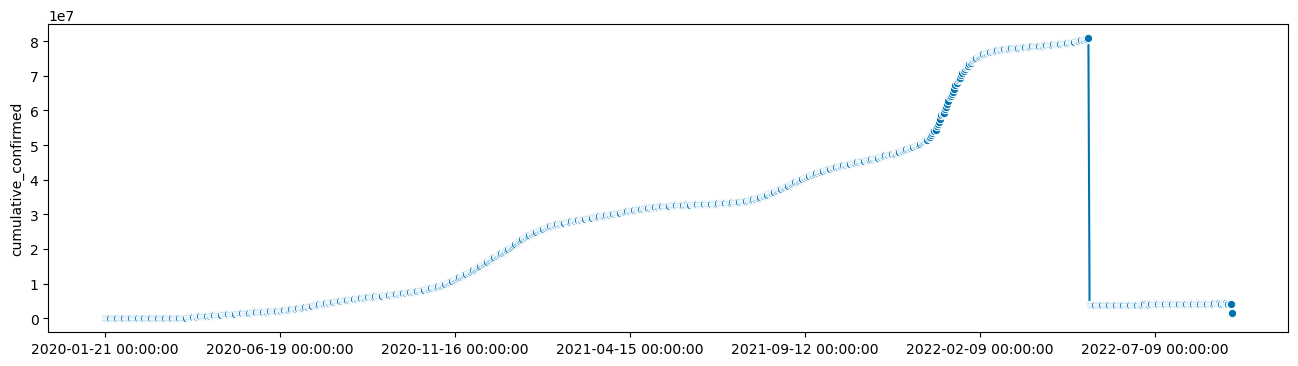

In [66]:
# Verify data quality

plot_series(df_cc.cumulative_confirmed);

In [115]:
# Most states stop reporting after 5/14/2022; end dataset at this date

df_cc = df_cc[df_cc.index < '2022-05-14']

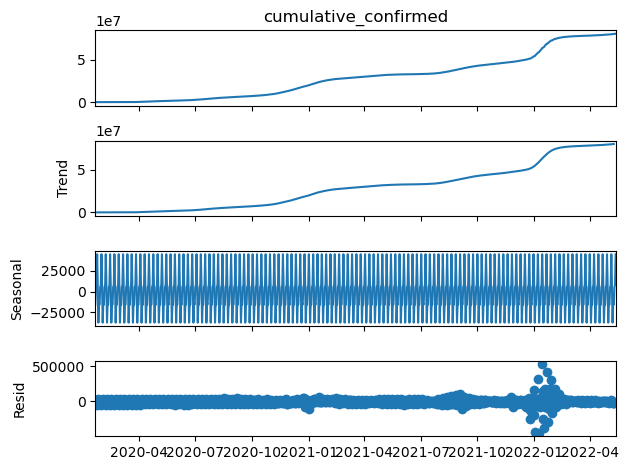

In [68]:
# Plot df_cc with associated trend, seasonality, and residual components assuming a linear trend

decomp_df_cc = seasonal_decompose(df_cc['cumulative_confirmed']) 
decomp_df_cc.plot();

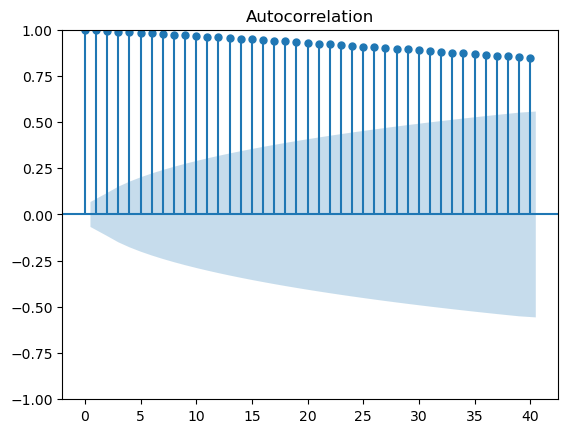

In [69]:
# Generate autocorrelation plot

plot_acf(df_cc['cumulative_confirmed'], lags = 40);

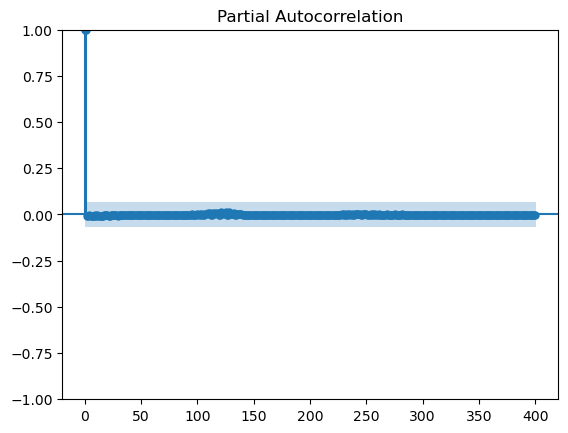

In [70]:
# Generate autocorrelation plot

plot_pacf(df_cc['cumulative_confirmed'], lags = 400);

In [116]:
# Add lag = 20 columns to df_cc and drop nulls

for i in range(1,11):
    df_cc[f'lag_{i}'] = df_cc['cumulative_confirmed'].shift(i)
    
df_cc.dropna(inplace = True)

/var/folders/qy/nr1f_j6j7nx50jtp9tqqgftc0000gn/T/ipykernel_17180/1574099588.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cc[f'lag_{i}'] = df_cc['cumulative_confirmed'].shift(i)
/var/folders/qy/nr1f_j6j7nx50jtp9tqqgftc0000gn/T/ipykernel_17180/1574099588.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cc[f'lag_{i}'] = df_cc['cumulative_confirmed'].shift(i)
/var/folders/qy/nr1f_j6j7nx50jtp9tqqgftc0000gn/T/ipykernel_17180/1574099588.py:4: SettingWithCopyWarning: 
A value is trying to be set on 

In [95]:
# TTS the y-lagged dataframe

X_train, X_test, y_train, y_test = train_test_split(df_cc.drop(columns = 'cumulative_confirmed'),
                                                    df_cc['cumulative_confirmed'],
                                                    shuffle = False)

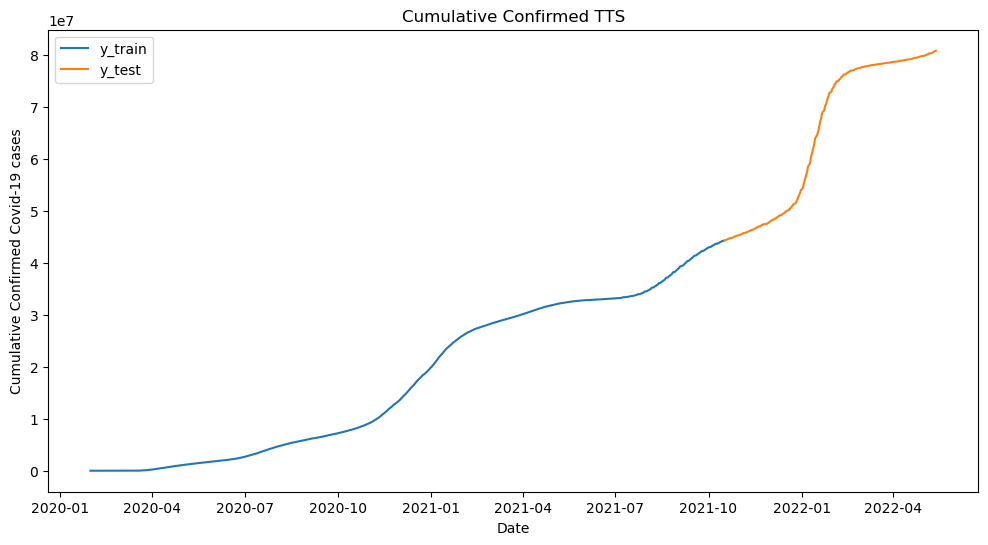

In [73]:
# Plot the TTS to ensure y is split properly

plt.figure(figsize = (12, 6))
plt.plot(y_train, label = 'y_train')
plt.plot(y_test, label = 'y_test')
plt.title('Cumulative Confirmed TTS')
plt.xlabel('Date')
plt.ylabel('Cumulative Confirmed Covid-19 cases')
plt.legend();

In [74]:
# Instantiate and fit a LR model on df_cc

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [75]:
# generate predictions over test set

y_preds = lr.predict(X_test)

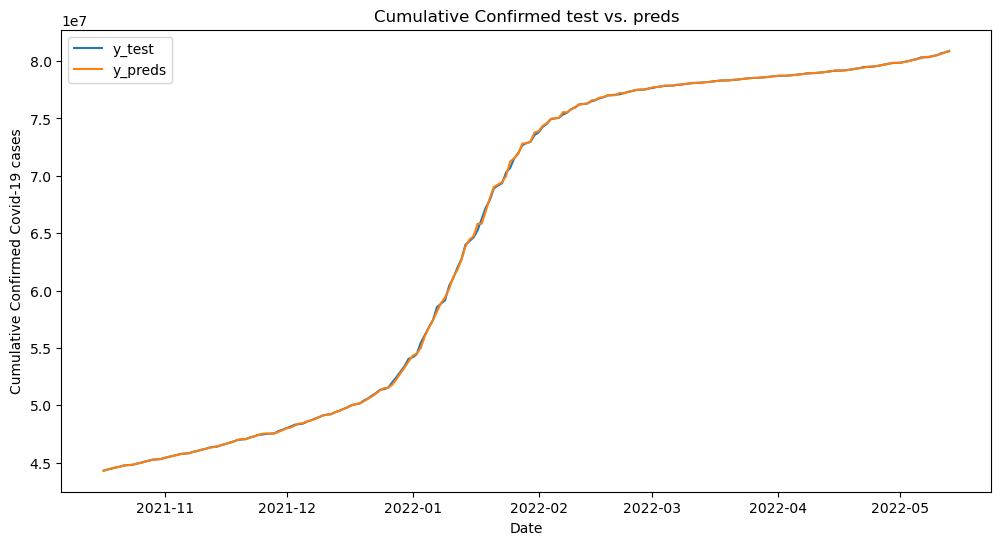

In [76]:
# plot predictions

plt.figure(figsize = (12, 6))
plt.plot(y_test, label = 'y_test')
plt.plot(y_test.index, y_preds, label = 'y_preds')
plt.title('Cumulative Confirmed test vs. preds')
plt.xlabel('Date')
plt.ylabel('Cumulative Confirmed Covid-19 cases')
plt.legend();

In [117]:
# Re-establish y

df_cc = df_cc[['cumulative_confirmed']]

In [78]:
# Augmented Dickey-Fuller test to determine stationarity

adfuller(df_cc)

(0.5332669889187962,
 0.9858499051442031,
 21,
 812,
 {'1%': -3.4384289321263126,
  '5%': -2.865105979079729,
  '10%': -2.568668841575869},
 19769.95955184543)

P-value is nearly 1, much greater than 0.05, so we can conclude the time series is not stationarity. We must improve stationarity to use ARIMA.

### Detrend dataset to improve stationarity
Source: GA 9.04-lesson-forecasint-ii

In [79]:
# reconfigure y in order to detrend

X = pd.to_numeric(df_cc.index)
X = X.to_numpy().reshape(-1, 1)
y = df_cc['cumulative_confirmed']

In [84]:
lr = LinearRegression()
lr.fit(X, y)

LinearRegression()

In [88]:
pred = lr.predict(X)
detrend = y - pred

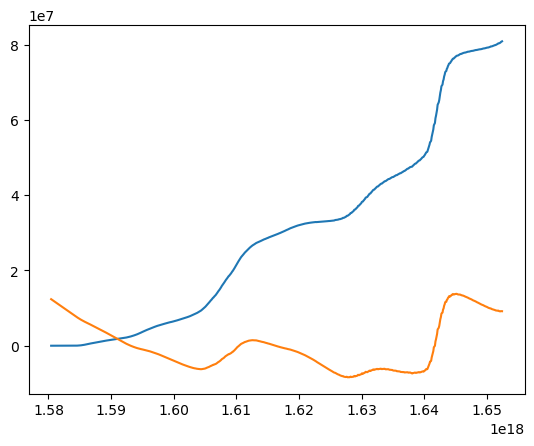

In [89]:
plt.plot(X, y);
plt.plot(X, detrend);

In [110]:
adfuller(detrend)

(-2.2039502066534595,
 0.20481488497148148,
 21,
 812,
 {'1%': -3.4384289321263126,
  '5%': -2.865105979079729,
  '10%': -2.568668841575869},
 19765.2684939286)

Detrending did not improve p-value to the point the dataset is stationary.

### Difference dataset to improve stationarity

In [118]:
# difference dataset

df_cc['difference'] = df_cc['cumulative_confirmed'].diff()

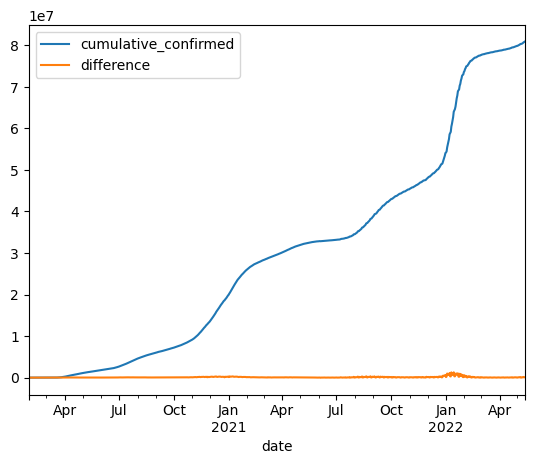

In [119]:
df_cc.plot();

In [121]:
df_cc.dropna(inplace = True)

In [122]:
adfuller(df_cc.difference)

(-3.3920477026494003,
 0.011232970633197104,
 21,
 811,
 {'1%': -3.4384389256151358,
  '5%': -2.8651103842072048,
  '10%': -2.568671188193778},
 19744.78532156366)

Using difference, p-value is now below 0.05; dataset exhibits stationarity.

### Create ARIMA model

In [126]:
y_train, y_test = temporal_train_test_split(df_cc['cumulative_confirmed'], test_size = 240)

In [127]:
model = pmd.auto_arima(y_train, d = 1, seasonal = False, trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=13905.052, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14845.084, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14178.344, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14590.104, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15271.412, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=13949.201, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13958.516, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=13887.371, Time=0.29 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=13927.213, Time=0.14 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=13881.933, Time=0.46 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=13910.145, Time=0.24 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=13871.144, Time=0.53 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=13905.892, Time=0.39 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=13898.069, Time=1.10 sec
 ARIMA(4,1,3)(0,0,0

In [128]:
model

ARIMA(order=(3, 1, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [130]:
auto_arima_preds = model.predict(240)

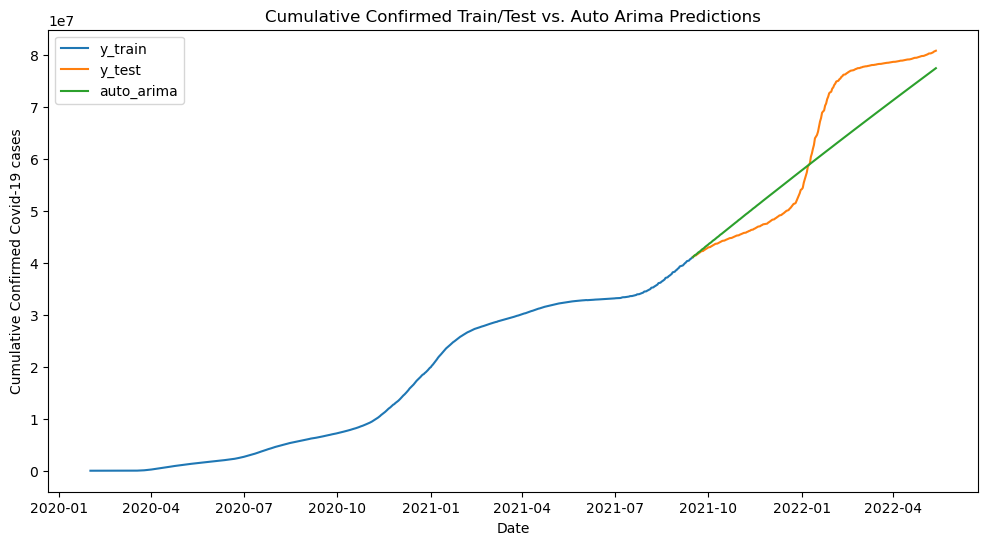

In [131]:
# plot predictions

plt.figure(figsize = (12, 6))
plt.plot(y_train, label = 'y_train')
plt.plot(y_test, label = 'y_test')
plt.plot(y_test.index, auto_arima_preds, label = 'auto_arima')
plt.title('Cumulative Confirmed Train/Test vs. Auto Arima Predictions')
plt.xlabel('Date')
plt.ylabel('Cumulative Confirmed Covid-19 cases')
plt.legend();